In [1]:
import copy
import numpy as np
from scipy import stats
import networkx as nx
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf) 

In [2]:
class Model(object):
    def __init__(self):
        self.cell_type={}
        self.organelle={}
        self.metabolite={}
        self.mtb_ImIndex = []
        self.mtb_G=nx.DiGraph()
    def load(self, path2meta_info, path2reaction):
        self.load_m(path2meta_info)
        self.load_r(path2reaction)    

    def load_m(self, path2meta_info):
        with open(path2meta_info) as f:
            for line in f.readlines():
                l = line.strip('\n').split('\t')
                if l[0] == "cell_type":
                    cell_abbr = l[1]
                    cell_marker = l[2]
                    cell_eng = l[3]
                    cell_chn = l[4]
                    if not self.cell_type.has_key(cell_abbr):
                        self.cell_type[cell_abbr]={'marker': cell_marker, 'name_eng': cell_eng, 'name_chn': cell_chn}
                    else:
                        if self.cell_type[cell_abbr]['marker'] != cell_marker \
                            or self.cell_type[cell_abbr]['name_eng'] != cell_eng \
                            or self.cell_type[cell_abbr]['name_chn'] != cell_chn:
                            print cell_abbr+" has be multiply defined. "
                elif l[0] == "organelle":
                    ogl_abbr = l[1]
                    ogl_marker = l[2]
                    ogl_eng = l[3]
                    ogl_chn = l[4]
                    if not  self.organelle.has_key(ogl_abbr):
                        self.organelle[ogl_abbr]={'marker': ogl_marker, 'name_eng': ogl_eng, 'name_chn': ogl_chn}
                    else:
                        if self.organelle[ogl_abbr]['marker'] != ogl_marker \
                            or self.organelle[ogl_abbr]['name_eng'] != ogl_eng \
                            or self.organelle[ogl_abbr]['name_chn'] != ogl_chn:
                            print ogl_abbr+" has be multiply defined. "
                elif l[0] == "metabolite":
                    mtb_abbr = l[1]
                    mtb_marker = l[2]
                    mtb_eng = l[3]
                    mtb_chn = l[4]
                    if not  self.metabolite.has_key(mtb_abbr):
                        self.metabolite[mtb_abbr]={'marker': mtb_marker, 'name_eng': mtb_eng, 'name_chn': mtb_chn}
                    else:
                        if self.metabolite[mtb_abbr]['marker'] != mtb_marker \
                            or self.metabolite[mtb_abbr]['name_eng'] != mtb_eng \
                            or self.metabolite[mtb_abbr]['name_chn'] != mtb_chn:
                            print mtb_abbr+" has be multiply defined. "
                else: 
                    print "Unrecognized label: "+ list[0]

        print str(len(self.cell_type))+"\tCell(s)" 
        print str(len(self.organelle))+"\tOrganelle(s)"
        print str(len(self.metabolite))+"\tMetabolite(s)"
    
    def load_r(self, path2reaction):
        mtb_set = set()
        with open(path2reaction) as f:
            i=0
            for line in f.readlines() :
                l = line.strip('\n').split('>')
                substrate=filter(None, l[0].split(';'))
                product=filter(None, l[1].split('#')[0].split(';'))
                note=l[1].split('#')[1]
                self.mtb_G.add_node(i, sub = [ tuple(s.split('.')) for s in substrate ], \
                                    prd = [ tuple(p.split('.')) for p in product ], \
                                    note = note)
                for e in self.mtb_G.nodes(data='sub'):
                    mtb_set = mtb_set.union(set(e[1]))
                for e in self.mtb_G.nodes(data='prd'):
                    mtb_set = mtb_set.union(set(e[1]))
                i+=1
            self.flux_tensor = np.zeros((i))
            self.mtb_ImIndex = list(mtb_set)
            for r1 in self.mtb_G:
                for successors in self.mtb_G.nodes[r1]['prd']:
                    for r2 in self.mtb_G:
                        if successors in self.mtb_G.nodes[r2]['sub']:
                            self.mtb_G.add_edge(r1, r2, mtb=successors)
                for predecessors in self.mtb_G.nodes[r1]['sub']:
                    for r2 in self.mtb_G:
                        if predecessors in self.mtb_G.nodes[r2]['prd']:
                            self.mtb_G.add_edge(r2, r1, mtb=predecessors)
            print str(i)+"\tReaction(s)"
            print str(self.mtb_G.number_of_edges())+"\tEdge(s)"


M=Model()
M.load('Metabolites.txt', 'Reactions.txt')
#Model loaded

1	Cell(s)
4	Organelle(s)
66	Metabolite(s)
59	Reaction(s)
65	Edge(s)


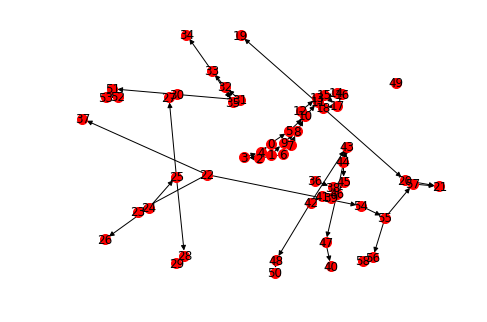

<Figure size 800x800 with 0 Axes>

In [3]:
nx.draw(M.mtb_G,pos=nx.spring_layout(M.mtb_G),node_size=100, with_labels=True)
plt.figure(figsize=(10,10), dpi=80)
plt.draw()

In [26]:
class Case(Model):
    def __init__(self, name, Model):
        super(Case,self).__init__()
        self.id = name
        self.metabolite = Model.metabolite
        self.mtb_ImIndex = Model.mtb_ImIndex
        self.mtb_G = Model.mtb_G
        self.mtb_ReIndex = []
        self.mtb_Re = 0
        self.R2I_Flux = 0
        self.mtb_Im = 0
        self.ImKinetics = np.zeros((len(self.mtb_G.nodes)))
    
    def load(self, index, data):
        self.mtb_ReIndex = index
        self.mtb_Re = data
        self.R2I_Flux = np.zeros((len(self.mtb_ReIndex),len(self.mtb_ImIndex)))
        self.R2I_Flux[:,:] = np.nan
        i = j = k = 0
        for i in range(0,len(self.mtb_ReIndex)):
            if '/' in self.mtb_ReIndex[i]:
                for mtb_s in self.mtb_ReIndex[i].split('/'):
                    for j in range(0,len(self.mtb_ImIndex)):
                        if mtb_s == self.mtb_ImIndex[j][0]:
                            self.R2I_Flux[i,j] = 1
                            k += 1
                    j = 0
            else:
                for j in range(0,len(self.mtb_ImIndex)):
                    if self.mtb_ReIndex[i] == self.mtb_ImIndex[j][0]:
                        self.R2I_Flux[i,j] = 1
                        k += 1
                j = 0
            for x in range(0,len(self.mtb_ImIndex)):
                if not np.isnan(self.R2I_Flux[i,x]):
                    self.R2I_Flux[i,x] = np.float32(1./k)
            k = 0
        i = 0
        
    def consistency_check(self):
        ans = []
        for i in self.mtb_ReIndex:
            flag = False
            if '/' in i:
                for j in i.split('/'):
                    for k in self.mtb_ImIndex:
                        if j == k[0]:
                            flag = True
                            break
            else:
                for k in self.mtb_ImIndex:
                    if i == k[0]:
                        flag = True
                        break
            if not flag:
                ans += [i]
        if len(ans) == 0:
            print "All metabolites are in model."
        else:
            print ", ".join(ans) +" is/are not in model."
        
    def random_flux_ratio(self):
        for i in range(0,self.R2I_Flux.shape[0]):
            idx = []
            val = []
            for j in range(0,self.R2I_Flux.shape[1]):
                if not np.isnan(self.R2I_Flux[i,j]):
                    idx += [j]
            if not len(idx) == 0:
                if len(idx) == 1:
                    val = [np.float32(1.)]
                elif len(idx) > 1:
                    sum = 0
                    for k in range(0,len(idx)-1):
                        y = (1-sum) * np.random.random_sample()
                        sum += y
                        val += [y]
                    val += [1-sum] 
            for a in range(0,len(idx)):
                self.R2I_Flux[i,idx[a]] = val[a]

    def Real2Imaginary(self):
        r = self.mtb_Re.shape[0]
        i = self.R2I_Flux.shape[1]
        self.mtb_Im = np.zeros((i))
        self.mtb_Im[:] = np.nan
        for x in range(0,r):
            for y in range(0,i):
                if not np.isnan(self.R2I_Flux[x,y]):
                    self.mtb_Im[y] = self.mtb_Re[x] * self.R2I_Flux[x,y]

    def Mtb2Kinetics(self):
        for r in self.mtb_G:
            X = Y = 1
            for i in self.mtb_G.nodes[r]['prd']:
                Y *= self.mtb_Im[self.mtb_ImIndex.index(i)]
            for j in self.mtb_G.nodes[r]['sub']:
                X *= self.mtb_Im[self.mtb_ImIndex.index(j)]
            self.ImKinetics[r] = np.float32(Y / X)

CaseSet = []
with open("SDG_info.txt") as f:
    CaseSet_info = [[sample.split(";") for sample in line.strip('\n').split("\t")] for line in f.readlines()]

with open("SDG_data.txt") as f:
    title = f.readline().strip('\n').split("\t")
    group = title[1:]
    dataset = np.asarray([line.strip('\n').split("\t") for line in f.readlines()])
    for i in range(0,len(group)):
        case = Case(group[i],M)
        case.load(dataset[:,0].tolist(),np.asarray(dataset[:,1+i], dtype=np.float32))
        CaseSet += [case]
        if i == 0:
            case.consistency_check()

αKG, FAD, E4P is/are not in model.


In [28]:
#CaseSet[0].random_flux_ratio()
CaseSet[0].Real2Imaginary()
CaseSet[0].Mtb2Kinetics()
#print CaseSet[0].ImKinetics

for i in range(1,5):
    CaseSet[i].R2I_Flux = CaseSet[0].R2I_Flux
    CaseSet[i].Real2Imaginary()
    CaseSet[i].Mtb2Kinetics()

#CaseSet[5].random_flux_ratio()
CaseSet[5].Real2Imaginary()
CaseSet[5].Mtb2Kinetics()
for i in range(6,10):
    CaseSet[i].R2I_Flux = CaseSet[5].R2I_Flux
    CaseSet[i].Real2Imaginary()
    CaseSet[i].Mtb2Kinetics()

KntSys_1 = CaseSet[0:5]
KntSys_2 = CaseSet[5:10]
    
def delta_flux(KntSys_1, KntSys_2):
    return (KntSys_2[0].R2I_Flux - KntSys_1[0].R2I_Flux) / KntSys_1[0].R2I_Flux

def delta_kinetics(KntSys_1, KntSys_2, s_cutoff):
    A = [case.ImKinetics for case in KntSys_1]
    B = [case.ImKinetics for case in KntSys_2]
    Knts4Sys1 = np.c_[A]
    Knts4Sys2 = np.c_[B]
    (h,l) = Knts4Sys1.shape
    equal_variances = np.zeros((l))
    dK_p = np.zeros((l))
    for i in range(0,l):
        if len(set(Knts4Sys1[:,i])-set(Knts4Sys2[:,i])) == 0:
            dK_p[i] = 0
        elif len(set(Knts4Sys1[:,i])) == 1 or len(set(Knts4Sys2[:,i])) == 1:
            dK_p[i] = ((Knts4Sys2[0,i] - Knts4Sys1[0,i]) / Knts4Sys1[0,i])
        else:
            if np.isnan(Knts4Sys1[:,i]).any() or np.isnan(Knts4Sys2[:,i]).any():
                equal_variances[i] = np.nan
                dK_p[i] = np.nan
            else:
                #equal_variances[i] = 1 if stats.levene(Knts4Sys1[:,i], Knts4Sys2[:,i])[1]<s_cutoff else 0 
                #dK_p[i] = (stats.ttest_ind(Knts4Sys1[:,i], Knts4Sys2[:,i], equal_var = equal_variances[i])[0])
                dK_p[i] = ((np.mean(Knts4Sys2[:,i])-np.mean(Knts4Sys1[:,i]))/np.mean(Knts4Sys1[:,i]))
        #print Knts4Sys1[:,i], Knts4Sys2[:,i]
        #print dK_p[i] 
    #print Knts4Sys1
    return dK_p
    
def penalty(dF, dK, cutoff):
    penalty = []
    for r in CaseSet[0].mtb_G:
        course = 0
        if dK[r] > cutoff:
            course += dK[r]       
        for p in set(CaseSet[0].mtb_G.nodes[r]['prd']).union(set(CaseSet[0].mtb_G.nodes[r]['sub'])):
            ratio = np.absolute(dF[:,CaseSet[0].mtb_ImIndex.index(p)])
            for a in ratio:
                if a>cutoff:
                    course += a
        if course > 0:
            penalty += [(r,course)] 
        penalty.sort(key=lambda x:x[1], reverse = True)
    return penalty

def flux_migration(R2I_Flux, ratio):
    for i in range(0,R2I_Flux.shape[0]):
        idx = []
        val = []
        for j in range(0,R2I_Flux.shape[1]):
            if not np.isnan(R2I_Flux[i,j]):
                idx += [j]
            if len(idx) > 1:
                sum = 0
                for k in range(0,len(idx)-1):
                    y = ratio * (np.random.random_sample()-0.5)
                    sum += y
                    val += [y]
                val += [0-sum] 
                for a in range(0,len(idx)):
                    R2I_Flux[i,idx[a]] += val[a]
    return R2I_Flux

dF = delta_flux(KntSys_1, KntSys_2)
dK = delta_kinetics(KntSys_1, KntSys_2, 0.05)
p_lst = penalty(dF,dK,0.1)
G_p = np.sum(np.array(list(p_lst))[:,1])
L_p = np.inf
i = 0
for i in range(0,10):
    while L_p >= G_p:
        oriFlux = 0
        if i/2 == 0:
            oriFlux = CaseSet[0].R2I_Flux
            CaseSet[0].R2I_Flux = flux_migration(CaseSet[0].R2I_Flux, 0.5)
        else:
            oriFlux = CaseSet[5].R2I_Flux
            CaseSet[5].R2I_Flux = flux_migration(CaseSet[5].R2I_Flux, 0.1)
        CaseSet[0].Real2Imaginary()
        CaseSet[0].Mtb2Kinetics()
        CaseSet[5].Real2Imaginary()
        CaseSet[5].Mtb2Kinetics()
        for i in range(1,5):
            CaseSet[i].R2I_Flux = CaseSet[0].R2I_Flux
            CaseSet[i].Real2Imaginary()
            CaseSet[i].Mtb2Kinetics()
        for i in range(6,10):
            CaseSet[i].R2I_Flux = CaseSet[5].R2I_Flux
            CaseSet[i].Real2Imaginary()
            CaseSet[i].Mtb2Kinetics()
        dF = delta_flux(KntSys_1, KntSys_2)
        dK = delta_kinetics(KntSys_1, KntSys_2, 0.05)
        p_lst = penalty(dF,dK,0.1)
        L_p = np.sum(np.array(list(p_lst))[:,1])
        if L_p < G_p:
            G_p = L_p
            print L_p
            break
        else:
            if i/2 == 0:
                CaseSet[0].R2I_Flux = oriFlux
            else:
                CaseSet[5].R2I_Flux = oriFlux
print L_p

18.29671072405569
18.29671069484745
18.29671066866431
18.296710663857738
18.296710648687128
18.296710418151484


KeyboardInterrupt: 

In [29]:
print p_lst

[(5, 5.518010900149284), (26, 4.643479768172765), (53, 2.1038872605552332), (30, 1.3504708100775482), (16, 0.8730220096061444), (15, 0.8618999237516621), (34, 0.7288635745125186), (6, 0.6363202992954254), (9, 0.4905514353595304), (11, 0.45549184224898653), (12, 0.45549183951028305), (37, 0.17922147051509454)]


In [41]:
CaseSet[0].mtb_G.nodes[37]

{'note': 'Photo Respiration',
 'prd': [('Glyce', 'chl', 'mes')],
 'sub': [('3PGA', 'chl', 'mes')]}